<a href="https://colab.research.google.com/github/BartVL71/python_eindwerk/blob/main/Criminaliteit_in_Gent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Overzicht en analyse van de criminaliteitsgegevens van Gent 2018-2023
##door Bart Van Lancker

##Initialiseren (imports)


In [ ]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

##Functie die de crimidata uit de API haalt en omzet naar hetgeen ons interesseert

In [ ]:
##functie verwerk_crimi_data
def verwerk_crimi_data (URL):
  response = requests.get(URL)
  if response.status_code == 200:   ##als alles ok is
    json_data = response.json()
    df = pd.DataFrame(json_data['records'])
    beperkt = df[['fields']].copy()  ##enkel wat in fields zit interesseert ons
    verdeeld = pd.json_normalize(beperkt['fields'])   ##fields uitpakken in verschillende columns in de df
    gestript = verdeeld.drop(columns=['geo_point_2d','geometry.coordinates','geometry.type'])  ##voor ons nutteloze kolommen weghalen
  else:   ##foutmelding geven
    print(f"Er is een fout opgetreden met code {response.status_code}")
  return gestript

##Lees de data van alle jaren in (elk jaar heeft zijn eigen dataset) en zet ze in één dataframe

In [ ]:
volledig = pd.DataFrame() ##leeg df aanmaken
for x in range(18,24):   ##iteratie over alle jaartallen (2018-2023)
  jaartal = '20' + str(x)
  url = "https://data.stad.gent/api/records/1.0/search/?dataset=criminaliteitscijfers-per-wijk-per-maand-gent-" + jaartal + "&q=&rows=5000"
  data = verwerk_crimi_data(url)
  volledig = pd.concat([volledig, data], ignore_index=True)  ##inhoud van ingelezen data van het jaar aan de df toevoegen

##Foutjes in de gegevens corrigeren
'Verkeersongevallen' zit er dubbel in, als 'Verkeerongevallen' en als 'Verkeersongevallen'
Wijken Stationsbuurt Noord en Zuid moeten een koppelteken hebben

In [ ]:
##foute waarde vervangen door de juiste waarde
volledig['fact_category'] = volledig['fact_category'].replace('Verkeerongevallen met lichamelijk letsel', 'Verkeersongevallen met lichamelijk letsel')
volledig['quarter'] = volledig ['quarter'].replace('Stationsbuurt Zuid', 'Stationsbuurt-Zuid')
volledig['quarter'] = volledig ['quarter'].replace('Stationsbuurt Noord', 'Stationsbuurt-Noord')

##Evolutie criminaliteit per jaar (lijnplot)

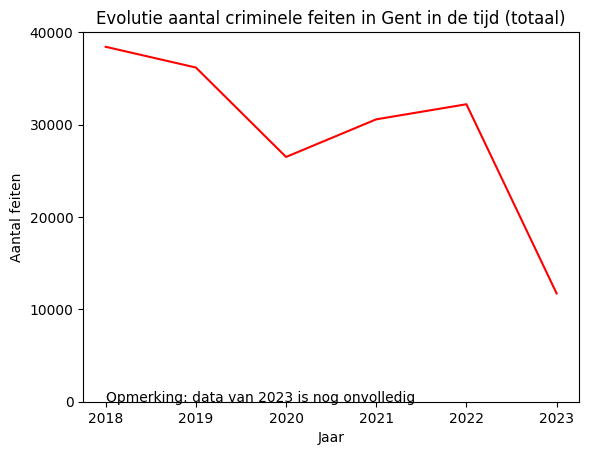

In [ ]:
##alles optellen per jaar
sommen_per_jaar = volledig['total'].groupby(volledig['year']).sum()
plt.plot(sommen_per_jaar, color='red')
plt.title('Evolutie aantal criminele feiten in Gent in de tijd (totaal)')
plt.xlabel('Jaar')
plt.ylabel('Aantal feiten')
plt.yticks ([0, 10000, 20000, 30000, 40000])   ##customizen van de y-as
tekst = 'Opmerking: data van 2023 is nog onvolledig'
plt.text(0, 0, tekst, fontsize=10)
plt.show()

##Evolutie criminaliteit per maand (lijnplot)

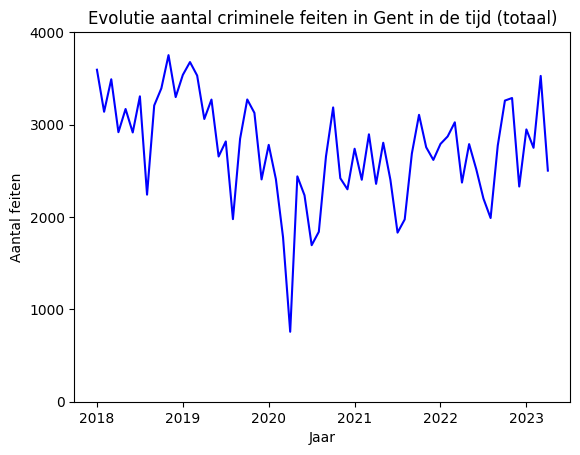

In [ ]:
##alles optellen per maand
sommen_per_maand = volledig['total'].groupby(volledig['jaar_maand']).sum()
plt.plot(sommen_per_maand, color='blue')
plt.title('Evolutie aantal criminele feiten in Gent in de tijd (totaal)')
plt.xlabel('Jaar')
plt.ylabel('Aantal feiten')
plt.yticks ([0, 1000, 2000, 3000, 4000])
xticks_lijst = ['2018-01-01', '2019-01-01','2020-01-01','2021-01-01','2022-01-01','2023-01-01']   ##x-as opkuisen door beperkt aantal labels te tonen
xticks_labels = [2018, 2019, 2020, 2021, 2022, 2023]   ##vervanglabels, zijn duidelijker
plt.xticks(xticks_lijst, xticks_labels)
plt.show()

In [ ]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 57.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 81.6 MB/s eta 0:00:00


##Haal de geodata op van alle Gentse wijken uit geojson bestand stadswijken-gent.geojson
###Dit bestand werd gegenereerd uit een dataset van de Gentse API
## + functie definiëren kaart_tekenen


In [ ]:
import geopandas as gp
import folium  ##leaflet kaarten
##drive mounten
from google.colab import drive
drive.mount('/content/drive')
# Set path to data
%cd "/content/drive/My Drive/Python_data"
##bestand lezen
wijkgeodata = gp.read_file("stadswijken-gent.geojson")    ##importeren als geodataframe

##functie kaart tekenen met indien gegeven, één of twee wijken in een andere kleur
def teken_kaart(eerste_wijk=None, tweede_wijk=None):   ##functie met twee argumenten, beide argumenten zijn optioneel
  if tweede_wijk==None and eerste_wijk==None:
    alles = True
  else:
    alles = False
  map = folium.Map(width=450, height=550, location=[51.100, 3.700], tiles='OpenStreetMap', zoom_start=11)    ##kaartlayout
  for _, r in wijkgeodata.iterrows():    ##grenzen op de kaart aanbrengen
      sim_geo = gp.GeoSeries(r['geometry']).simplify(tolerance=0.001)   ##grenzen een beetje gesimplifieerd
      geo_j = sim_geo.to_json()
      if alles:
        geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {'fillColor': 'red'})
      elif (r['wijk'] == eerste_wijk) or (r['wijk'] == tweede_wijk):
        geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {'fillColor': 'green'})
      else:
        geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {'fillColor': 'transparent'})
      folium.Popup(r['wijk'], tooltip=r['wijk']).add_to(geo_j)   ##tooltip met naam van de wijk
      geo_j.add_to(map)
  display(map)

Mounted at /content/drive
/content/drive/My Drive/Python_data


##Totaal aantal feiten per wijk (lijst + staafdiagram)

De 5 wijken met het hoogst aantal criminele feiten zijn:

Binnenstad                   39848
Brugse Poort - Rooigem       16687
Sluizeken - Tolhuis - Ham    14273
Ledeberg                     10451
Dampoort                      9739


De 5 wijken met het laagst aantal criminele feiten zijn:

Gentse Kanaaldorpen en -zone     335
Zwijnaarde                      1124
Moscou - Vogelhoek              1481
Oostakker                       1520
Gentbrugge                      1524


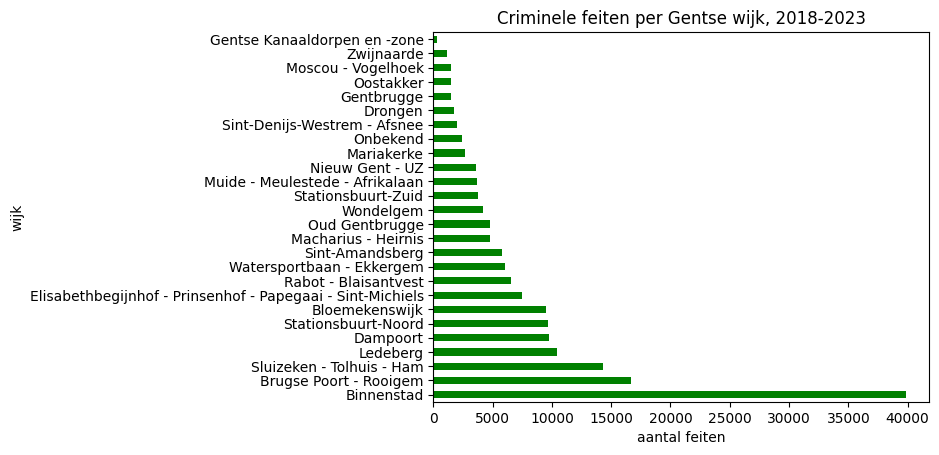

In [ ]:
##alles optellen per wijk
sommen_per_wijk = volledig['total'].groupby(volledig['quarter']).sum().sort_values(ascending=False)
sommen_per_wijk_df = sommen_per_wijk.to_frame().reset_index()
sommen_per_wijk_df.columns = ['wijk','aantal_feiten']
print ('De 5 wijken met het hoogst aantal criminele feiten zijn:\n')
slechtste_vijf = sommen_per_wijk.head(5)
print(slechtste_vijf.to_string(header=False))  ##omzetten naar string om de header eraf te halen
print ('\n')
print ('De 5 wijken met het laagst aantal criminele feiten zijn:\n')
beste_vijf = sommen_per_wijk.tail(5).sort_values()
print(beste_vijf.to_string(header=False))
sommen_per_wijk.plot.barh(color="green", ylabel="wijk", xlabel="aantal feiten", title="Criminele feiten per Gentse wijk, 2018-2023")
plt.show()

##Chloropleth kaart "heatmap" van dezelfde data
###elke wijk heeft een kleur volgens het aantal criminele feiten

In [ ]:
map = folium.Map(width=450, height=550, location=[51.100, 3.700], tiles="OpenStreetMap", zoom_start=11)    ##kaartlayout
folium.Choropleth(
    geo_data = wijkgeodata,
    name = 'Choropleth',
    data = sommen_per_wijk_df,
    columns = ['wijk','aantal_feiten'],
    key_on = 'feature.properties.wijk',
    fill_color = 'YlOrRd',   ##voorgedefinieerde kleurgradiënt
    fill_opacity = 0.4,
    line_opacity = 1,
    legend_name = 'Aantal feiten',
    smooth_factor=  0
).add_to(map)
map

##Twee wijken vergelijken / evolutie per maand



We gaan Elisabethbegijnhof - Prinsenhof - Papegaai - Sint-Michiels met Zwijnaarde vergelijken!




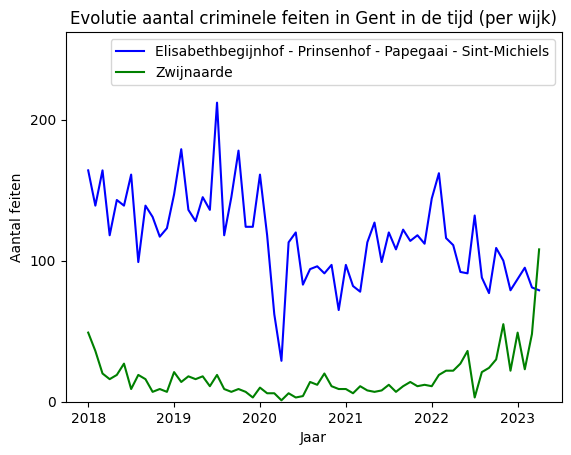

In [ ]:
##dict maken van wijken met hun quarter_code
##eerst twee lijsten maken
wijken_lijst = []
wijknr_lijst = []
for rows in volledig.itertuples():
  wijk =rows.quarter
  wijknr = rows.quarter_code
  if wijk not in wijken_lijst:
    wijken_lijst.append(wijk)  ##toevoegen aan dict als wijk er nog niet instaat
    wijknr_lijst.append(wijknr)
wijken_dict = dict(zip(wijknr_lijst, wijken_lijst)) ##omzetten naar een dict {wijknr:wijknaam}
##maak een df van de dict, om gemakkelijk te kunnen weergeven
wijken_df = pd.DataFrame.from_dict(wijken_dict, orient='index')
wijken_df.reset_index(inplace=True)
wijken_df.columns = ['wijknr','wijknaam']
wijken_df_sorted = wijken_df.sort_values(by=['wijknr'])
##print de lijst van wijken en vraagt om invoer
teken_kaart()  ##zonder argumenten, dus alle wijken krijgen dezelfde kleur
print(wijken_df_sorted.to_string(index=False))
print ('\n')
wijk1 = int(input('Geef het nummer van eerste wijk die u wil analyseren: '))
wijknaam1 = wijken_dict.get(wijk1)
wijk2 = int(input ('Geef het nummer van de tweede wijk die u wil analyseren: '))
wijknaam2 = wijken_dict.get(wijk2)
clear_output()
print (f"We gaan {wijknaam1} met {wijknaam2} vergelijken!")
print ('\n')
teken_kaart (wijknaam1, wijknaam2)  ##teken de kaart met de gekozen wijken in het groen
print ('\n')
##df maken voor wijk 1 en 2
df_wijk1 = volledig.loc[volledig['quarter_code'] == wijk1]
df_wijk2 = volledig.loc[volledig['quarter_code'] == wijk2]
##som per maand maken  + max. waarde bepalen voor de twee wijken
som_per_maand_1 = df_wijk1['total'].groupby(df_wijk1['jaar_maand']).sum()
max_1 = som_per_maand_1.max()
som_per_maand_2 = df_wijk2['total'].groupby(df_wijk2['jaar_maand']).sum()
##maximale waarde uit de reeks bepalen; doel: goed leesbare grafiek
max_2 = som_per_maand_2.max()
if max_1 > max_2:
  maximum = max_1
else:
  maximum = max_2
plt.plot(som_per_maand_1, color='blue', label=wijknaam1)    ##wijk 1, met kleur en label
plt.plot(som_per_maand_2, color='green', label=wijknaam2)
plt.title('Evolutie aantal criminele feiten in Gent in de tijd (per wijk)')
plt.xlabel('Jaar')
plt.ylabel('Aantal feiten')
if maximum < 1000:   ##yticks aanpassen aan maximale waarde uit de reeks
  plt.yticks ([0, 100, 200, 300, 400, 500, 600, 700, 800, 900])
else:
  plt.yticks ([0, 200, 400, 600, 800, 1000])
plt.ylim([0,maximum + 50])    ##y-as zoveel mogelijk aligneren met de max waarde
xticks_lijst = ['2018-01-01', '2019-01-01','2020-01-01','2021-01-01','2022-01-01','2023-01-01']   ##x-as opkuisen door beperkt aantal labels te tonen
xticks_labels = [2018, 2019, 2020, 2021, 2022, 2023]   ##vervanglabels, zijn duidelijker
plt.xticks(xticks_lijst, xticks_labels)
plt.legend()
plt.show()

##Evolutie types criminaliteit in de stad

 index                                  misdrijf
     1                   Diefstal gewapenderhand
     2          Diefstal met geweld zonder wapen
     3            Diefstal uit of aan voertuigen
     4                             Fietsdiefstal
     5                             Geluidshinder
     6                                  Graffiti
     7         Inbraak in bedrijf of handelszaak
     8                             Motordiefstal
     9                      Parkeerovertredingen
    10                              Sluikstorten
    11 Verkeersongevallen met lichamelijk letsel
    12                             Woninginbraak
    13                            Zakkenrollerij
    14                              Autodiefstal
    15                     Beschadiging aan auto
    16                         Bromfietsdiefstal


Geef het type misdrijf dat u wenst te visualiseren: 9


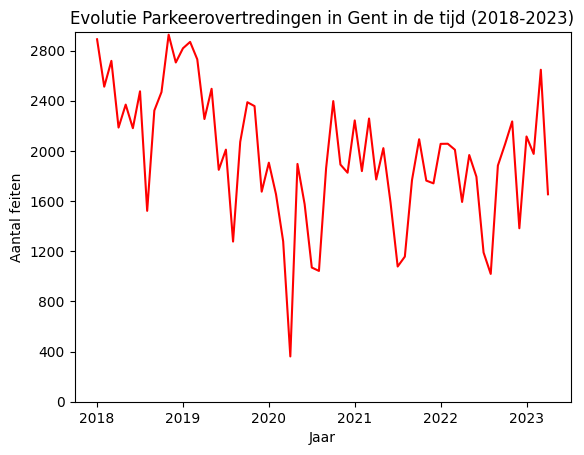

In [ ]:
##lijst maken van alle soorten criminaliteit in het df
crimi_lijst = []
for rows in volledig.itertuples():   ##itertuples() is sneller dan interrows()
  item =rows.fact_category   ##elk item in de kolom fact_category wordt overlopen
  if item not in crimi_lijst:
    crimi_lijst.append(item)  ##toevoegen aan lijst als item er nog niet instaat
##omzetten in een dict met rangnummer/index
crimi_dict = dict(zip(range(1, len(crimi_lijst)+1),crimi_lijst ))
##maak een df van de dict, om gemakkelijk te kunnen weergeven
crimi_df = pd.DataFrame.from_dict(crimi_dict, orient='index')
crimi_df.reset_index(inplace=True)
crimi_df.columns = ['index', 'misdrijf']
##print de lijst van types criminaliteit en vraagt om invoer
print(crimi_df.to_string(index=False))
print ('\n')
type_misdrijf_index = int(input('Geef het type misdrijf dat u wenst te visualiseren: '))
type_misdrijf = crimi_dict[type_misdrijf_index]
##nieuw df maken met enkel het gekozen type misdaad
df_misdaad = volledig.loc[volledig['fact_category'] == type_misdrijf]
##som per maand bepalen + max. waarde
som_misdrijf_per_maand = df_misdaad['total'].groupby(df_misdaad['jaar_maand']).sum()
max_per_maand = som_misdrijf_per_maand.max()
##plotten lijndiagram
plt.plot(som_misdrijf_per_maand, color='red', label=type_misdrijf)
plt.title(f"Evolutie {type_misdrijf} in Gent in de tijd (2018-2023)")
plt.xlabel('Jaar')
plt.ylabel('Aantal feiten')
if max_per_maand > 500:
  plt.yticks ([0, 400, 800, 1200, 1600, 2000, 2400, 2800, 3200])
else:
  plt.yticks ([0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340])
plt.ylim([0,max_per_maand + 20])    ##y-as zoveel mogelijk aligneren met de max waarde
xticks_lijst = ['2018-01-01', '2019-01-01','2020-01-01','2021-01-01','2022-01-01','2023-01-01']   ##x-as opkuisen door beperkt aantal labels te tonen
xticks_labels = [2018, 2019, 2020, 2021, 2022, 2023]   ##vervanglabels, zijn duidelijker
plt.xticks(xticks_lijst, xticks_labels)
plt.show()

##Meest voorkomende types criminaliteit per wijk

In [ ]:
##print de lijst van wijken en vraagt om invoer
teken_kaart()  ##zonder argumenten, dus alle wijken krijgen dezelfde kleur
print(wijken_df_sorted.to_string(index=False))
print ('\n')
wijk1 = int(input('Geef het nummer van de wijk die u wil analyseren: '))
wijknaam = wijken_dict.get(wijk1)
clear_output()
print (f"We gaan {wijknaam} analyseren!")
print ('\n')
teken_kaart (wijknaam)  ##teken de kaart met de gekozen wijken in het groen
print ('\n')
##alles optellen per crimi in de wijk
##nieuw dataframe, enkel deze wijk
crimi_per_wijk = volledig[volledig['quarter']==wijknaam]
##sommen maken per crimi in het nieuwe dataframen en sorteren
crimi_per_wijk_som = crimi_per_wijk['total'].groupby(crimi_per_wijk['fact_category']).sum().sort_values(ascending=False)
crimi_per_wijk_som_df = crimi_per_wijk_som.to_frame().reset_index()
print ('\n')
print(f"In de wijk {wijknaam} zijn dit de soorten feiten, gerangschikt van veel naar weinig gevallen:")
print ('\n')
print (crimi_per_wijk_som_df.to_string(header=False, index=False))

We gaan Macharius - Heirnis analyseren!








In de wijk Macharius - Heirnis zijn dit de soorten feiten, gerangschikt van veel naar weinig gevallen:


                     Parkeerovertredingen 3399
                            Fietsdiefstal  417
           Diefstal uit of aan voertuigen  186
                            Woninginbraak  166
                    Beschadiging aan auto  151
Verkeersongevallen met lichamelijk letsel  107
                            Geluidshinder  101
                             Sluikstorten   70
         Diefstal met geweld zonder wapen   49
        Inbraak in bedrijf of handelszaak   45
                        Bromfietsdiefstal   25
                           Zakkenrollerij   15
                                 Graffiti   14
                             Autodiefstal   11
                            Motordiefstal   11
                  Diefstal gewapenderhand    5


##Dataframe output naar een csv file

In [ ]:
##volledig df converteren naar csv en naar bestand schrijven
volledig.to_csv('crimi.csv', sep=',', index=False)   ##alles met komma ertussen zonder index wordt in csv gestoken